In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, accuracy_score, average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2024-07-18 16:26:34.484800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/easybuild_allnodes/software/Qhull/2020.2-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/LibTIFF/4.3.0-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/libdeflate/1.10-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/zstd/1.5.2-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/lz4/1.9.3-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/jbigkit/2.1-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/libjpeg-turbo/2.1.3-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/Tk/8.6.12-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/X11/20220504-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/software/fontconfig/2.14.0-GCCcore-11.3.0/lib:/usr/local/easybuild_allnodes/softw

In [2]:
# Define the path to the folders
base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork'
folders = ['DNA_BERT2', 'HyenaDNA', 'mistral','nucleotide-transformer-500m-human-ref']

In [3]:
# Dictionary to store matrices
matrices = {}

# Read and store matrices
for folder in folders:
    print(folder)
    folder_path = os.path.join(base_path, folder)
    for file_name in os.listdir(folder_path):
        print(file_name)
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            if folder == 'nucleotide-transformer-500m-human-ref':
                emb_file =  np.load(file_path)
                matrices[file_name] = np.matrix(emb_file) 
            else:
                emb_file =  np.load(file_path,allow_pickle=True)
                matrices[file_name] = np.vstack(np.array(emb_file))


DNA_BERT2
test_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy
test_human_enhancers_cohn_DB2_Embeddings.npy
test_human_enhancers_ensembl_DB2_Embeddings.npy
test_human_ensembl_regulatory_DB2_Embeddings.npy
test_human_nontata_promoters_DB2_Embeddings.npy
test_human_ocr_ensembl_DB2_Embeddings.npy
train_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy
train_human_enhancers_cohn_DB2_Embeddings.npy
train_human_enhancers_ensembl_DB2_Embeddings.npy
train_human_ensembl_regulatory_DB2_Embeddings.npy
train_human_nontata_promoters_DB2_Embeddings.npy
train_human_ocr_ensembl_DB2_Embeddings.npy
HyenaDNA
test_demo_coding_vs_intergenomic_seqs_HD_Embeddings.npy
test_human_enhancers_cohn_HD_Embeddings.npy
test_human_enhancers_ensembl_HD_Embeddings.npy
test_human_ensembl_regulatory_HD_Embeddings.npy
test_human_nontata_promoters_HD_Embeddings.npy
test_human_ocr_ensembl_HD_Embeddings.npy
train_demo_coding_vs_intergenomic_seqs_HD_Embeddings.npy
train_human_enhancers_cohn_HD_Embeddings.npy
train_human_

In [4]:
# Define a function for calculating sensitivity and specificity
def sensitivity_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

# Define a function to build the 1D CNN model
def build_1d_cnn(input_shape):
    from keras.models import Sequential
    from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

# demo_coding_vs_intergenomic_seqs

In [5]:
train = pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/train_demo_coding_vs_intergenomic_seqs.csv')
test =  pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/test_demo_coding_vs_intergenomic_seqs.csv')
print(train.shape)
print(test.shape)

(75000, 2)
(25000, 2)


In [6]:
train.head()

,seq,label
0,TGTTATTGGCCAGGCACGGAGGCTCATGCCTGTAATCCCAGCACTT...,1
1,TTGCCAATTTCTAAAAAATCCCAGCATCTCTTGTGGATTGCTGACT...,1
2,TGGAGATAAAGAGATTGGATGGAGGACATGGGAAAAAGGATGACAG...,1
3,GTACAGGGATGAGGGAGTGGCCTGAGCTGGAAATGCCCCAGTTTAG...,1
4,AAGTTAACTGTTAAGTCTCATTGTGATGCCCTAAAGGGGAGAAACT...,1


In [7]:
train_DB2 = matrices['train_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy']
test_DB2 = matrices['test_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy']

train_HD = matrices['train_demo_coding_vs_intergenomic_seqs_HD_Embeddings.npy']
test_HD = matrices['test_demo_coding_vs_intergenomic_seqs_HD_Embeddings.npy']

train_mis = matrices['train_demo_coding_vs_intergenomic_seqs_mistral_Embeddings.npy']
test_mis = matrices['test_demo_coding_vs_intergenomic_seqs_mistral_Embeddings.npy']

train_NT_500m_ref = matrices['train_demo_coding_vs_intergenomic_seqs_NT_Embeddings.npy']
test_NT_500m_ref = matrices['test_demo_coding_vs_intergenomic_seqs_NT_Embeddings.npy']


In [8]:
train_NT_500m_ref.shape

(75000, 1280)

In [9]:
train_labels = train['label'].values  
test_labels = test['label'].values  
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Example of adding labels to embeddings (replace with your actual embeddings)
train_DB2_labeled = np.hstack((train_DB2, train_labels.reshape(-1, 1)))
test_DB2_labeled = np.hstack((test_DB2, test_labels.reshape(-1, 1)))

train_HD_labeled = np.hstack((train_HD, train_labels.reshape(-1, 1)))
test_HD_labeled = np.hstack((test_HD, test_labels.reshape(-1, 1)))

train_mis_labeled = np.hstack((train_mis, train_labels.reshape(-1, 1)))
test_mis_labeled = np.hstack((test_mis, test_labels.reshape(-1, 1)))

train_NT_500m_ref_labeled = np.hstack((train_NT_500m_ref, train_labels.reshape(-1, 1)))
test_NT_500m_ref_labeled = np.hstack((test_NT_500m_ref, test_labels.reshape(-1, 1)))

In [11]:
# Encode labels to one-hot vectors
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)
train_labels_onehot = to_categorical(train_labels_encoded)
test_labels_onehot = to_categorical(test_labels_encoded)

# Initialize lists to store combined features and labels
combined_X_train = []
combined_X_test = []

# Initialize lists to store prediction results
results = []

# Train the model with each set of features
for train_data, test_data, name in zip(
        [train_DB2_labeled, train_HD_labeled, train_mis_labeled, train_NT_500m_ref_labeled],
        [test_DB2_labeled, test_HD_labeled, test_mis_labeled, test_NT_500m_ref_labeled],
        ['DB2', 'HD', 'Mistral', 'NT_500m_ref']):
    
    X_train, y_train = train_data[:, :-1], train_labels_onehot
    X_test, y_test = test_data[:, :-1], test_labels_onehot
    
    # Reshape data to fit the model input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    input_shape = (X_train.shape[1], 1)
    model = build_1d_cnn(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Training model with {name} features...")
    
    # Train the model and capture the training history
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Predicting the probabilities and the classes
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculating evaluation metrics
    f1 = f1_score(y_test_classes, y_pred_classes)
    auroc = roc_auc_score(y_test, y_pred_probs)
    precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())
    auprc = auc(recall, precision)
    sensitivity, specificity = sensitivity_specificity(y_test_classes, y_pred_classes)
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    # Save results
    results.append([name, accuracy, f1, auroc, auprc, sensitivity, specificity])
    
    print(f"Evaluation metrics for {name} features:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"AUROC: {auroc}")
    print(f"AUPRC: {auprc}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    # Collect the features and predictions
    combined_X_train.append(train_data[:, :-1])
    combined_X_test.append(test_data[:, :-1])

# Combine features from all models
combined_X_train = np.concatenate(combined_X_train, axis=1)
combined_X_test = np.concatenate(combined_X_test, axis=1)

# Reshape combined features
combined_X_train = combined_X_train.reshape((combined_X_train.shape[0], combined_X_train.shape[1], 1))
combined_X_test = combined_X_test.reshape((combined_X_test.shape[0], combined_X_test.shape[1], 1))

# Define and compile a new model for combined features
input_shape = (combined_X_train.shape[1], 1)
combined_model = build_1d_cnn(input_shape)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with combined features
print("Training model with combined features...")
combined_history = combined_model.fit(combined_X_train, train_labels_onehot, epochs=10, batch_size=32, validation_data=(combined_X_test, test_labels_onehot))


# Predicting the probabilities and the classes
combined_y_pred_probs = combined_model.predict(combined_X_test)
combined_y_pred_classes = np.argmax(combined_y_pred_probs, axis=1)
combined_y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Calculating evaluation metrics for combined features
combined_f1 = f1_score(combined_y_test_classes, combined_y_pred_classes)
combined_auroc = roc_auc_score(test_labels_onehot, combined_y_pred_probs)
combined_precision, combined_recall, _ = precision_recall_curve(test_labels_onehot.ravel(), combined_y_pred_probs.ravel())
combined_auprc = auc(combined_recall, combined_precision)
combined_sensitivity, combined_specificity = sensitivity_specificity(combined_y_test_classes, combined_y_pred_classes)
combined_accuracy = combined_model.evaluate(combined_X_test, test_labels_onehot, verbose=0)[1]

# Save combined features results
results.append(['Combined', combined_accuracy, combined_f1, combined_auroc, combined_auprc, combined_sensitivity, combined_specificity])

print("Evaluation metrics for combined features:")
print(f"Accuracy: {combined_accuracy}")
print(f"F1 Score: {combined_f1}")
print(f"AUROC: {combined_auroc}")
print(f"AUPRC: {combined_auprc}")
print(f"Sensitivity: {combined_sensitivity}")
print(f"Specificity: {combined_specificity}")

Training model with DB2 features...
Epoch 1/10
2344/2344 [==============================] - 36s 15ms/step - loss: 0.2940 - accuracy: 0.8764 - val_loss: 0.2374 - val_accuracy: 0.9016
Epoch 2/10
2344/2344 [==============================] - 35s 15ms/step - loss: 0.2525 - accuracy: 0.8981 - val_loss: 0.2431 - val_accuracy: 0.8973
Epoch 3/10
2344/2344 [==============================] - 36s 15ms/step - loss: 0.2411 - accuracy: 0.9033 - val_loss: 0.2242 - val_accuracy: 0.9062
Epoch 4/10
2344/2344 [==============================] - 36s 15ms/step - loss: 0.2337 - accuracy: 0.9064 - val_loss: 0.2266 - val_accuracy: 0.9047
Epoch 5/10
2344/2344 [==============================] - 35s 15ms/step - loss: 0.2296 - accuracy: 0.9071 - val_loss: 0.2252 - val_accuracy: 0.9071
Epoch 6/10
2344/2344 [==============================] - 35s 15ms/step - loss: 0.2224 - accuracy: 0.9104 - val_loss: 0.2335 - val_accuracy: 0.9027
Epoch 7/10
2344/2344 [==============================] - 35s 15ms/step - loss: 0.2197 - a

In [13]:
# Adding the character-level tokenization results
train_sequences = train['seq']
train_labels = train['label']  
test_sequences = test['seq']
test_labels = test['label']  

# Initialize Tokenizer and fit on training sequences
tokenizer = Tokenizer(char_level=True)  # Use char_level=True for character-level tokenization
tokenizer.fit_on_texts(train_sequences)

# Convert sequences to sequences of integers
train_sequences_encoded = tokenizer.texts_to_sequences(train_sequences)
test_sequences_encoded = tokenizer.texts_to_sequences(test_sequences)

# Pad sequences to ensure consistent input size
max_len = max(len(seq) for seq in train_sequences_encoded + test_sequences_encoded)
X_train = pad_sequences(train_sequences_encoded, maxlen=max_len)
X_test = pad_sequences(test_sequences_encoded, maxlen=max_len)

# Convert labels to numpy array
y_train = np.array(train_labels)
y_test = np.array(test_labels)

input_shape = (X_train.shape[1], 1)  # (sequence_length, 1) for 1D CNN
model = build_1d_cnn(input_shape)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to add a channel dimension
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
auprc = average_precision_score(y_test, y_pred[:, 1])

sensitivity, specificity = sensitivity_specificity(y_test, y_pred_classes)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUROC:", roc_auc)
print("AUPRC:", auprc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(classification_report(y_test, y_pred_classes))

# Optionally, you can plot training history to visualize the training process
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the character-level tokenization results
results.append(['CharLevelTokenizer', accuracy, f1, roc_auc, auprc, sensitivity, specificity])

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4877 - accuracy: 0.7686 - val_loss: 0.6585 - val_accuracy: 0.6373
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.4143 - accuracy: 0.8116 - val_loss: 0.4686 - val_accuracy: 0.7496
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3797 - accuracy: 0.8297 - val_loss: 0.7192 - val_accuracy: 0.6307
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3570 - accuracy: 0.8411 - val_loss: 0.6017 - val_accuracy: 0.6925
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3390 - accuracy: 0.8521 - val_loss: 0.5663 - val_accuracy: 0.7315
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3197 - accuracy: 0.8621 - val_loss: 0.5785 - val_accuracy: 0.7315
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3049 - accuracy: 0.8705 - val_loss: 0.6481 - val_ac

/tmp/job.1709652.hpc/ipykernel_309369/1233734977.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [14]:
# Create a DataFrame and save results
results_df = pd.DataFrame(results, columns=['Feature Set', 'Accuracy', 'F1 Score', 'AUROC', 'AUPRC', 'Sensitivity', 'Specificity'])
results_df.to_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Coding_prediction_results.csv', index=False)

In [15]:
results_df

,Feature Set,Accuracy,F1 Score,AUROC,AUPRC,Sensitivity,Specificity
0,DB2,0.90912,0.909525,0.970761,0.971009,0.91360,0.90464
1,HD,0.86408,0.860818,0.942019,0.941665,0.84064,0.88752
2,Mistral,0.88096,0.879524,0.954561,0.955645,0.86904,0.89288
3,NT_500m_ref,0.88504,0.883907,0.954949,0.955636,0.87528,0.89480
4,Combined,0.91412,0.913529,0.972529,0.972906,0.90728,0.92096
5,CharLevelTokenizer,0.84448,0.851080,0.927048,0.924909,0.88880,0.80016


# human_enhancers_cohn

In [16]:
train = pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/train_human_enhancers_cohn.csv')
test =  pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/test_human_enhancers_cohn.csv')
print(train.shape)
print(test.shape)

(20843, 2)
(6948, 2)


In [17]:
train_DB2 = matrices['train_human_enhancers_cohn_DB2_Embeddings.npy']
test_DB2 = matrices['test_human_enhancers_cohn_DB2_Embeddings.npy']

train_HD = matrices['train_human_enhancers_cohn_HD_Embeddings.npy']
test_HD = matrices['test_human_enhancers_cohn_HD_Embeddings.npy']

train_mis = matrices['train_human_enhancers_cohn_mistral_Embeddings.npy']
test_mis = matrices['test_human_enhancers_cohn_mistral_Embeddings.npy']

train_NT_25b_1000G = matrices['train_human_enhancers_cohn_NT_Embeddings.npy']
test_NT_25b_1000G = matrices['test_human_enhancers_cohn_NT_Embeddings.npy']

train_NT_500m_1000G = matrices['train_human_enhancers_cohn_NT_Embeddings.npy']
test_NT_500m_1000G = matrices['test_human_enhancers_cohn_NT_Embeddings.npy']

train_NT_500m_ref = matrices['train_human_enhancers_cohn_NT_Embeddings.npy']
test_NT_500m_ref = matrices['test_human_enhancers_cohn_NT_Embeddings.npy']


In [18]:
train_labels = train['label'].values  
test_labels = test['label'].values  
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Example of adding labels to embeddings (replace with your actual embeddings)
train_DB2_labeled = np.hstack((train_DB2, train_labels.reshape(-1, 1)))
test_DB2_labeled = np.hstack((test_DB2, test_labels.reshape(-1, 1)))

train_HD_labeled = np.hstack((train_HD, train_labels.reshape(-1, 1)))
test_HD_labeled = np.hstack((test_HD, test_labels.reshape(-1, 1)))

train_mis_labeled = np.hstack((train_mis, train_labels.reshape(-1, 1)))
test_mis_labeled = np.hstack((test_mis, test_labels.reshape(-1, 1)))

train_NT_500m_ref_labeled = np.hstack((train_NT_500m_ref, train_labels.reshape(-1, 1)))
test_NT_500m_ref_labeled = np.hstack((test_NT_500m_ref, test_labels.reshape(-1, 1)))


In [19]:
# Encode labels to one-hot vectors
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)
train_labels_onehot = to_categorical(train_labels_encoded)
test_labels_onehot = to_categorical(test_labels_encoded)

# Initialize lists to store combined features and labels
combined_X_train = []
combined_X_test = []

# Initialize lists to store prediction results
results = []

# Train the model with each set of features
for train_data, test_data, name in zip(
        [train_DB2_labeled, train_HD_labeled, train_mis_labeled, train_NT_500m_ref_labeled],
        [test_DB2_labeled, test_HD_labeled, test_mis_labeled, test_NT_500m_ref_labeled],
        ['DB2', 'HD', 'Mistral', 'NT_500m_ref']):
    
    X_train, y_train = train_data[:, :-1], train_labels_onehot
    X_test, y_test = test_data[:, :-1], test_labels_onehot
    
    # Reshape data to fit the model input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    input_shape = (X_train.shape[1], 1)
    model = build_1d_cnn(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Training model with {name} features...")
    
    # Train the model and capture the training history
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Predicting the probabilities and the classes
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculating evaluation metrics
    f1 = f1_score(y_test_classes, y_pred_classes)
    auroc = roc_auc_score(y_test, y_pred_probs)
    precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())
    auprc = auc(recall, precision)
    sensitivity, specificity = sensitivity_specificity(y_test_classes, y_pred_classes)
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    # Save results
    results.append([name, accuracy, f1, auroc, auprc, sensitivity, specificity])
    
    print(f"Evaluation metrics for {name} features:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"AUROC: {auroc}")
    print(f"AUPRC: {auprc}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    # Collect the features and predictions
    combined_X_train.append(train_data[:, :-1])
    combined_X_test.append(test_data[:, :-1])

# Combine features from all models
combined_X_train = np.concatenate(combined_X_train, axis=1)
combined_X_test = np.concatenate(combined_X_test, axis=1)

# Reshape combined features
combined_X_train = combined_X_train.reshape((combined_X_train.shape[0], combined_X_train.shape[1], 1))
combined_X_test = combined_X_test.reshape((combined_X_test.shape[0], combined_X_test.shape[1], 1))

# Define and compile a new model for combined features
input_shape = (combined_X_train.shape[1], 1)
combined_model = build_1d_cnn(input_shape)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with combined features
print("Training model with combined features...")
combined_history = combined_model.fit(combined_X_train, train_labels_onehot, epochs=10, batch_size=32, validation_data=(combined_X_test, test_labels_onehot))


# Predicting the probabilities and the classes
combined_y_pred_probs = combined_model.predict(combined_X_test)
combined_y_pred_classes = np.argmax(combined_y_pred_probs, axis=1)
combined_y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Calculating evaluation metrics for combined features
combined_f1 = f1_score(combined_y_test_classes, combined_y_pred_classes)
combined_auroc = roc_auc_score(test_labels_onehot, combined_y_pred_probs)
combined_precision, combined_recall, _ = precision_recall_curve(test_labels_onehot.ravel(), combined_y_pred_probs.ravel())
combined_auprc = auc(combined_recall, combined_precision)
combined_sensitivity, combined_specificity = sensitivity_specificity(combined_y_test_classes, combined_y_pred_classes)
combined_accuracy = combined_model.evaluate(combined_X_test, test_labels_onehot, verbose=0)[1]

# Save combined features results
results.append(['Combined', combined_accuracy, combined_f1, combined_auroc, combined_auprc, combined_sensitivity, combined_specificity])

print("Evaluation metrics for combined features:")
print(f"Accuracy: {combined_accuracy}")
print(f"F1 Score: {combined_f1}")
print(f"AUROC: {combined_auroc}")
print(f"AUPRC: {combined_auprc}")
print(f"Sensitivity: {combined_sensitivity}")
print(f"Specificity: {combined_specificity}")


Training model with DB2 features...
Epoch 1/10
652/652 [==============================] - 10s 15ms/step - loss: 0.5515 - accuracy: 0.7095 - val_loss: 0.5202 - val_accuracy: 0.7353
Epoch 2/10
652/652 [==============================] - 10s 15ms/step - loss: 0.5223 - accuracy: 0.7372 - val_loss: 0.5087 - val_accuracy: 0.7450
Epoch 3/10
652/652 [==============================] - 10s 15ms/step - loss: 0.5128 - accuracy: 0.7426 - val_loss: 0.5036 - val_accuracy: 0.7468
Epoch 4/10
652/652 [==============================] - 10s 15ms/step - loss: 0.5062 - accuracy: 0.7471 - val_loss: 0.5065 - val_accuracy: 0.7484
Epoch 5/10
652/652 [==============================] - 10s 15ms/step - loss: 0.5029 - accuracy: 0.7502 - val_loss: 0.4989 - val_accuracy: 0.7517
Epoch 6/10
652/652 [==============================] - 10s 15ms/step - loss: 0.4994 - accuracy: 0.7513 - val_loss: 0.5010 - val_accuracy: 0.7486
Epoch 7/10
652/652 [==============================] - 10s 15ms/step - loss: 0.4942 - accuracy: 0.752

In [20]:
# Adding the character-level tokenization results
train_sequences = train['seq']
train_labels = train['label']  
test_sequences = test['seq']
test_labels = test['label']  

# Initialize Tokenizer and fit on training sequences
tokenizer = Tokenizer(char_level=True)  # Use char_level=True for character-level tokenization
tokenizer.fit_on_texts(train_sequences)

# Convert sequences to sequences of integers
train_sequences_encoded = tokenizer.texts_to_sequences(train_sequences)
test_sequences_encoded = tokenizer.texts_to_sequences(test_sequences)

# Pad sequences to ensure consistent input size
max_len = max(len(seq) for seq in train_sequences_encoded + test_sequences_encoded)
X_train = pad_sequences(train_sequences_encoded, maxlen=max_len)
X_test = pad_sequences(test_sequences_encoded, maxlen=max_len)

# Convert labels to numpy array
y_train = np.array(train_labels)
y_test = np.array(test_labels)

input_shape = (X_train.shape[1], 1)  # (sequence_length, 1) for 1D CNN
model = build_1d_cnn(input_shape)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to add a channel dimension
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
auprc = average_precision_score(y_test, y_pred[:, 1])

sensitivity, specificity = sensitivity_specificity(y_test, y_pred_classes)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUROC:", roc_auc)
print("AUPRC:", auprc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(classification_report(y_test, y_pred_classes))

# Save the character-level tokenization results
results.append(['CharLevelTokenizer', accuracy, f1, roc_auc, auprc, sensitivity, specificity])

Epoch 1/10
522/522 [==============================] - 6s 11ms/step - loss: 0.6599 - accuracy: 0.6367 - val_loss: 1.0414 - val_accuracy: 0.1554
Epoch 2/10
522/522 [==============================] - 5s 10ms/step - loss: 0.6081 - accuracy: 0.6748 - val_loss: 0.6814 - val_accuracy: 0.5495
Epoch 3/10
522/522 [==============================] - 5s 10ms/step - loss: 0.5935 - accuracy: 0.6884 - val_loss: 1.0950 - val_accuracy: 0.2336
Epoch 4/10
522/522 [==============================] - 5s 11ms/step - loss: 0.5782 - accuracy: 0.7026 - val_loss: 0.9289 - val_accuracy: 0.3567
Epoch 5/10
522/522 [==============================] - 5s 10ms/step - loss: 0.5544 - accuracy: 0.7188 - val_loss: 0.8742 - val_accuracy: 0.4142
Epoch 6/10
522/522 [==============================] - 6s 11ms/step - loss: 0.5264 - accuracy: 0.7437 - val_loss: 0.8723 - val_accuracy: 0.4526
Epoch 7/10
522/522 [==============================] - 6s 11ms/step - loss: 0.4791 - accuracy: 0.7753 - val_loss: 0.8336 - val_accuracy: 0.5126

In [21]:
# Create a DataFrame and save results
results_df = pd.DataFrame(results, columns=['Feature Set', 'Accuracy', 'F1 Score', 'AUROC', 'AUPRC', 'Sensitivity', 'Specificity'])
results_df.to_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Enhancer_cohn_prediction_results.csv', index=False)

In [22]:
results_df

,Feature Set,Accuracy,F1 Score,AUROC,AUPRC,Sensitivity,Specificity
0,DB2,0.754893,0.762714,0.836127,0.836429,0.787853,0.721934
1,HD,0.715314,0.716131,0.798417,0.799735,0.718192,0.712435
2,Mistral,0.702792,0.712436,0.783000,0.783090,0.736327,0.669257
3,NT_500m_ref,0.732441,0.751504,0.819515,0.819039,0.809154,0.655728
4,Combined,0.749856,0.751714,0.832356,0.832726,0.757340,0.742372
5,CharLevelTokenizer,0.622625,0.546994,0.680476,0.667500,0.455671,0.789580


#  enhancers_ensembl

In [23]:
train = pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/train_human_enhancers_ensembl.csv')
test =  pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/test_human_enhancers_ensembl.csv')
print(train.shape)
print(test.shape)

(123872, 2)
(30970, 2)


In [24]:
train_DB2 = matrices['train_human_enhancers_ensembl_DB2_Embeddings.npy']
test_DB2 = matrices['test_human_enhancers_ensembl_DB2_Embeddings.npy']

train_HD = matrices['train_human_enhancers_ensembl_HD_Embeddings.npy']
test_HD = matrices['test_human_enhancers_ensembl_HD_Embeddings.npy']

train_mis = matrices['train_human_enhancers_ensembl_mistral_Embeddings.npy']
test_mis = matrices['test_human_enhancers_ensembl_mistral_Embeddings.npy']

train_NT_500m_ref = matrices['train_human_enhancers_ensembl_NT_Embeddings.npy']
test_NT_500m_ref = matrices['test_human_enhancers_ensembl_NT_Embeddings.npy']


In [25]:
train_labels = train['label'].values  
test_labels = test['label'].values  
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Example of adding labels to embeddings (replace with your actual embeddings)
train_DB2_labeled = np.hstack((train_DB2, train_labels.reshape(-1, 1)))
test_DB2_labeled = np.hstack((test_DB2, test_labels.reshape(-1, 1)))

train_HD_labeled = np.hstack((train_HD, train_labels.reshape(-1, 1)))
test_HD_labeled = np.hstack((test_HD, test_labels.reshape(-1, 1)))

train_mis_labeled = np.hstack((train_mis, train_labels.reshape(-1, 1)))
test_mis_labeled = np.hstack((test_mis, test_labels.reshape(-1, 1)))

train_NT_500m_ref_labeled = np.hstack((train_NT_500m_ref, train_labels.reshape(-1, 1)))
test_NT_500m_ref_labeled = np.hstack((test_NT_500m_ref, test_labels.reshape(-1, 1)))


In [ ]:
# Encode labels to one-hot vectors

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)
train_labels_onehot = to_categorical(train_labels_encoded)
test_labels_onehot = to_categorical(test_labels_encoded)

# Initialize lists to store combined features and labels
combined_X_train = []
combined_X_test = []

# Initialize lists to store prediction results
results = []

# Train the model with each set of features
for train_data, test_data, name in zip(
        [train_DB2_labeled, train_HD_labeled, train_mis_labeled, train_NT_500m_ref_labeled],
        [test_DB2_labeled, test_HD_labeled, test_mis_labeled, test_NT_500m_ref_labeled],
        ['DB2', 'HD', 'Mistral', 'NT_500m_ref']):
    
    X_train, y_train = train_data[:, :-1], train_labels_onehot
    X_test, y_test = test_data[:, :-1], test_labels_onehot
    
    # Reshape data to fit the model input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    input_shape = (X_train.shape[1], 1)
    model = build_1d_cnn(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Training model with {name} features...")
    
    # Train the model and capture the training history
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Predicting the probabilities and the classes
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculating evaluation metrics
    f1 = f1_score(y_test_classes, y_pred_classes)
    auroc = roc_auc_score(y_test, y_pred_probs)
    precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())
    auprc = auc(recall, precision)
    sensitivity, specificity = sensitivity_specificity(y_test_classes, y_pred_classes)
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    # Save results
    results.append([name, accuracy, f1, auroc, auprc, sensitivity, specificity])
    
    print(f"Evaluation metrics for {name} features:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"AUROC: {auroc}")
    print(f"AUPRC: {auprc}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    # Collect the features and predictions
    combined_X_train.append(train_data[:, :-1])
    combined_X_test.append(test_data[:, :-1])

# Combine features from all models
combined_X_train = np.concatenate(combined_X_train, axis=1)
combined_X_test = np.concatenate(combined_X_test, axis=1)

# Reshape combined features
combined_X_train = combined_X_train.reshape((combined_X_train.shape[0], combined_X_train.shape[1], 1))
combined_X_test = combined_X_test.reshape((combined_X_test.shape[0], combined_X_test.shape[1], 1))

# Define and compile a new model for combined features
input_shape = (combined_X_train.shape[1], 1)
combined_model = build_1d_cnn(input_shape)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with combined features
print("Training model with combined features...")
combined_history = combined_model.fit(combined_X_train, train_labels_onehot, epochs=10, batch_size=32, validation_data=(combined_X_test, test_labels_onehot))


# Predicting the probabilities and the classes
combined_y_pred_probs = combined_model.predict(combined_X_test)
combined_y_pred_classes = np.argmax(combined_y_pred_probs, axis=1)
combined_y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Calculating evaluation metrics for combined features
combined_f1 = f1_score(combined_y_test_classes, combined_y_pred_classes)
combined_auroc = roc_auc_score(test_labels_onehot, combined_y_pred_probs)
combined_precision, combined_recall, _ = precision_recall_curve(test_labels_onehot.ravel(), combined_y_pred_probs.ravel())
combined_auprc = auc(combined_recall, combined_precision)
combined_sensitivity, combined_specificity = sensitivity_specificity(combined_y_test_classes, combined_y_pred_classes)
combined_accuracy = combined_model.evaluate(combined_X_test, test_labels_onehot, verbose=0)[1]

# Save combined features results
results.append(['Combined', combined_accuracy, combined_f1, combined_auroc, combined_auprc, combined_sensitivity, combined_specificity])

print("Evaluation metrics for combined features:")
print(f"Accuracy: {combined_accuracy}")
print(f"F1 Score: {combined_f1}")
print(f"AUROC: {combined_auroc}")
print(f"AUPRC: {combined_auprc}")
print(f"Sensitivity: {combined_sensitivity}")
print(f"Specificity: {combined_specificity}")

# Save prediction results to a CSV file
results_df = pd.DataFrame(results, columns=['Feature Set', 'Accuracy', 'F1 Score', 'AUROC', 'AUPRC', 'Sensitivity', 'Specificity'])
results_df.to_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/enhancers_ensembl_prediction_results.csv', index=False)
print("Prediction results saved to prediction_results.csv")


Training model with DB2 features...
Epoch 1/10
3871/3871 [==============================] - 57s 15ms/step - loss: 0.5724 - accuracy: 0.7067 - val_loss: 0.5746 - val_accuracy: 0.6922
Epoch 2/10
3871/3871 [==============================] - 59s 15ms/step - loss: 0.5363 - accuracy: 0.7344 - val_loss: 0.5209 - val_accuracy: 0.7364
Epoch 3/10
3871/3871 [==============================] - 55s 14ms/step - loss: 0.5249 - accuracy: 0.7432 - val_loss: 0.5079 - val_accuracy: 0.7494
Epoch 4/10
3871/3871 [==============================] - 55s 14ms/step - loss: 0.5158 - accuracy: 0.7481 - val_loss: 0.5044 - val_accuracy: 0.7527
Epoch 5/10
3871/3871 [==============================] - 55s 14ms/step - loss: 0.5081 - accuracy: 0.7528 - val_loss: 0.5014 - val_accuracy: 0.7544
Epoch 6/10
3871/3871 [==============================] - 54s 14ms/step - loss: 0.5016 - accuracy: 0.7559 - val_loss: 0.5010 - val_accuracy: 0.7549
Epoch 7/10
3871/3871 [==============================] - 56s 14ms/step - loss: 0.4944 - a

In [ ]:
# Adding the character-level tokenization results
train_sequences = train['seq']
train_labels = train['label']  
test_sequences = test['seq']
test_labels = test['label']  

# Initialize Tokenizer and fit on training sequences
tokenizer = Tokenizer(char_level=True)  # Use char_level=True for character-level tokenization
tokenizer.fit_on_texts(train_sequences)

# Convert sequences to sequences of integers
train_sequences_encoded = tokenizer.texts_to_sequences(train_sequences)
test_sequences_encoded = tokenizer.texts_to_sequences(test_sequences)

# Pad sequences to ensure consistent input size
max_len = max(len(seq) for seq in train_sequences_encoded + test_sequences_encoded)
X_train = pad_sequences(train_sequences_encoded, maxlen=max_len)
X_test = pad_sequences(test_sequences_encoded, maxlen=max_len)

# Convert labels to numpy array
y_train = np.array(train_labels)
y_test = np.array(test_labels)

input_shape = (X_train.shape[1], 1)  # (sequence_length, 1) for 1D CNN
model = build_1d_cnn(input_shape)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to add a channel dimension
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
auprc = average_precision_score(y_test, y_pred[:, 1])

sensitivity, specificity = sensitivity_specificity(y_test, y_pred_classes)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUROC:", roc_auc)
print("AUPRC:", auprc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(classification_report(y_test, y_pred_classes))

# Save the character-level tokenization results
results.append(['CharLevelTokenizer', accuracy, f1, roc_auc, auprc, sensitivity, specificity])

In [ ]:
# Create a DataFrame and save results
results_df = pd.DataFrame(results, columns=['Feature Set', 'Accuracy', 'F1 Score', 'AUROC', 'AUPRC', 'Sensitivity', 'Specificity'])
results_df.to_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/human_enhancers_ensembl_results.csv', index=False)

In [ ]:
results_df

# nontata_promoters

In [ ]:
train = pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/train_human_nontata_promoters.csv')
test =  pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/test_human_nontata_promoters.csv')
print(train.shape)
print(test.shape)

In [ ]:
train_DB2 = matrices['train_human_nontata_promoters_DB2_Embeddings.npy']
test_DB2 = matrices['test_human_nontata_promoters_DB2_Embeddings.npy']

train_HD = matrices['train_human_nontata_promoters_HD_Embeddings.npy']
test_HD = matrices['test_human_nontata_promoters_HD_Embeddings.npy']

train_mis = matrices['train_human_nontata_promoters_mistral_Embeddings.npy']
test_mis = matrices['test_human_nontata_promoters_mistral_Embeddings.npy']

train_NT_500m_ref = matrices['train_human_nontata_promoters_NT_Embeddings.npy']
test_NT_500m_ref = matrices['test_human_nontata_promoters_NT_Embeddings.npy']


In [ ]:
train_labels = train['label'].values  
test_labels = test['label'].values  
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Example of adding labels to embeddings (replace with your actual embeddings)
train_DB2_labeled = np.hstack((train_DB2, train_labels.reshape(-1, 1)))
test_DB2_labeled = np.hstack((test_DB2, test_labels.reshape(-1, 1)))

train_HD_labeled = np.hstack((train_HD, train_labels.reshape(-1, 1)))
test_HD_labeled = np.hstack((test_HD, test_labels.reshape(-1, 1)))

train_mis_labeled = np.hstack((train_mis, train_labels.reshape(-1, 1)))
test_mis_labeled = np.hstack((test_mis, test_labels.reshape(-1, 1)))

train_NT_500m_ref_labeled = np.hstack((train_NT_500m_ref, train_labels.reshape(-1, 1)))
test_NT_500m_ref_labeled = np.hstack((test_NT_500m_ref, test_labels.reshape(-1, 1)))



In [ ]:
# Encode labels to one-hot vectors
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)
train_labels_onehot = to_categorical(train_labels_encoded)
test_labels_onehot = to_categorical(test_labels_encoded)

# Initialize lists to store combined features and labels
combined_X_train = []
combined_X_test = []

# Initialize lists to store prediction results
results = []

# Train the model with each set of features
for train_data, test_data, name in zip(
        [train_DB2_labeled, train_HD_labeled, train_mis_labeled, train_NT_500m_ref_labeled],
        [test_DB2_labeled, test_HD_labeled, test_mis_labeled, test_NT_500m_ref_labeled],
        ['DB2', 'HD', 'Mistral', 'NT_500m_ref']):
    
    X_train, y_train = train_data[:, :-1], train_labels_onehot
    X_test, y_test = test_data[:, :-1], test_labels_onehot
    
    # Reshape data to fit the model input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    input_shape = (X_train.shape[1], 1)
    model = build_1d_cnn(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Training model with {name} features...")
    
    # Train the model and capture the training history
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Predicting the probabilities and the classes
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculating evaluation metrics
    f1 = f1_score(y_test_classes, y_pred_classes)
    auroc = roc_auc_score(y_test, y_pred_probs)
    precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())
    auprc = auc(recall, precision)
    sensitivity, specificity = sensitivity_specificity(y_test_classes, y_pred_classes)
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    # Save results
    results.append([name, accuracy, f1, auroc, auprc, sensitivity, specificity])
    
    print(f"Evaluation metrics for {name} features:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"AUROC: {auroc}")
    print(f"AUPRC: {auprc}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    # Collect the features and predictions
    combined_X_train.append(train_data[:, :-1])
    combined_X_test.append(test_data[:, :-1])

# Combine features from all models
combined_X_train = np.concatenate(combined_X_train, axis=1)
combined_X_test = np.concatenate(combined_X_test, axis=1)

# Reshape combined features
combined_X_train = combined_X_train.reshape((combined_X_train.shape[0], combined_X_train.shape[1], 1))
combined_X_test = combined_X_test.reshape((combined_X_test.shape[0], combined_X_test.shape[1], 1))

# Define and compile a new model for combined features
input_shape = (combined_X_train.shape[1], 1)
combined_model = build_1d_cnn(input_shape)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with combined features
print("Training model with combined features...")
combined_history = combined_model.fit(combined_X_train, train_labels_onehot, epochs=10, batch_size=32, validation_data=(combined_X_test, test_labels_onehot))


# Predicting the probabilities and the classes
combined_y_pred_probs = combined_model.predict(combined_X_test)
combined_y_pred_classes = np.argmax(combined_y_pred_probs, axis=1)
combined_y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Calculating evaluation metrics for combined features
combined_f1 = f1_score(combined_y_test_classes, combined_y_pred_classes)
combined_auroc = roc_auc_score(test_labels_onehot, combined_y_pred_probs)
combined_precision, combined_recall, _ = precision_recall_curve(test_labels_onehot.ravel(), combined_y_pred_probs.ravel())
combined_auprc = auc(combined_recall, combined_precision)
combined_sensitivity, combined_specificity = sensitivity_specificity(combined_y_test_classes, combined_y_pred_classes)
combined_accuracy = combined_model.evaluate(combined_X_test, test_labels_onehot, verbose=0)[1]

# Save combined features results
results.append(['Combined', combined_accuracy, combined_f1, combined_auroc, combined_auprc, combined_sensitivity, combined_specificity])

print("Evaluation metrics for combined features:")
print(f"Accuracy: {combined_accuracy}")
print(f"F1 Score: {combined_f1}")
print(f"AUROC: {combined_auroc}")
print(f"AUPRC: {combined_auprc}")
print(f"Sensitivity: {combined_sensitivity}")
print(f"Specificity: {combined_specificity}")


In [ ]:
# Adding the character-level tokenization results
train_sequences = train['seq']
train_labels = train['label']  
test_sequences = test['seq']
test_labels = test['label']  

# Initialize Tokenizer and fit on training sequences
tokenizer = Tokenizer(char_level=True)  # Use char_level=True for character-level tokenization
tokenizer.fit_on_texts(train_sequences)

# Convert sequences to sequences of integers
train_sequences_encoded = tokenizer.texts_to_sequences(train_sequences)
test_sequences_encoded = tokenizer.texts_to_sequences(test_sequences)

# Pad sequences to ensure consistent input size
max_len = max(len(seq) for seq in train_sequences_encoded + test_sequences_encoded)
X_train = pad_sequences(train_sequences_encoded, maxlen=max_len)
X_test = pad_sequences(test_sequences_encoded, maxlen=max_len)

# Convert labels to numpy array
y_train = np.array(train_labels)
y_test = np.array(test_labels)

input_shape = (X_train.shape[1], 1)  # (sequence_length, 1) for 1D CNN
model = build_1d_cnn(input_shape)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to add a channel dimension
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
auprc = average_precision_score(y_test, y_pred[:, 1])

sensitivity, specificity = sensitivity_specificity(y_test, y_pred_classes)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUROC:", roc_auc)
print("AUPRC:", auprc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(classification_report(y_test, y_pred_classes))

# Save the character-level tokenization results
results.append(['CharLevelTokenizer', accuracy, f1, roc_auc, auprc, sensitivity, specificity])

In [ ]:
# Create a DataFrame and save results
results_df = pd.DataFrame(results, columns=['Feature Set', 'Accuracy', 'F1 Score', 'AUROC', 'AUPRC', 'Sensitivity', 'Specificity'])
results_df.to_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/human_nontata_promoters_results.csv', index=False)

In [ ]:
results_df

# Result plots

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
coding = pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Coding_prediction_results.csv')
enhancer_cohn = pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Enhancer_cohn_prediction_results.csv')
enhancer_ens= pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/enhancers_ensembl_prediction_results.csv')
promoter = pd.read_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/nontata_promoters_prediction_results.csv')

In [12]:
coding

,Feature Set,Accuracy,F1 Score,AUROC,AUPRC,Sensitivity,Specificity
0,DB2,0.90912,0.909525,0.970761,0.971009,0.91360,0.90464
1,HD,0.86408,0.860818,0.942019,0.941665,0.84064,0.88752
2,Mistral,0.88096,0.879524,0.954561,0.955645,0.86904,0.89288
3,NT_500m_ref,0.88504,0.883907,0.954949,0.955636,0.87528,0.89480
4,Combined,0.91412,0.913529,0.972529,0.972906,0.90728,0.92096
5,CharLevelTokenizer,0.84448,0.851080,0.927048,0.924909,0.88880,0.80016


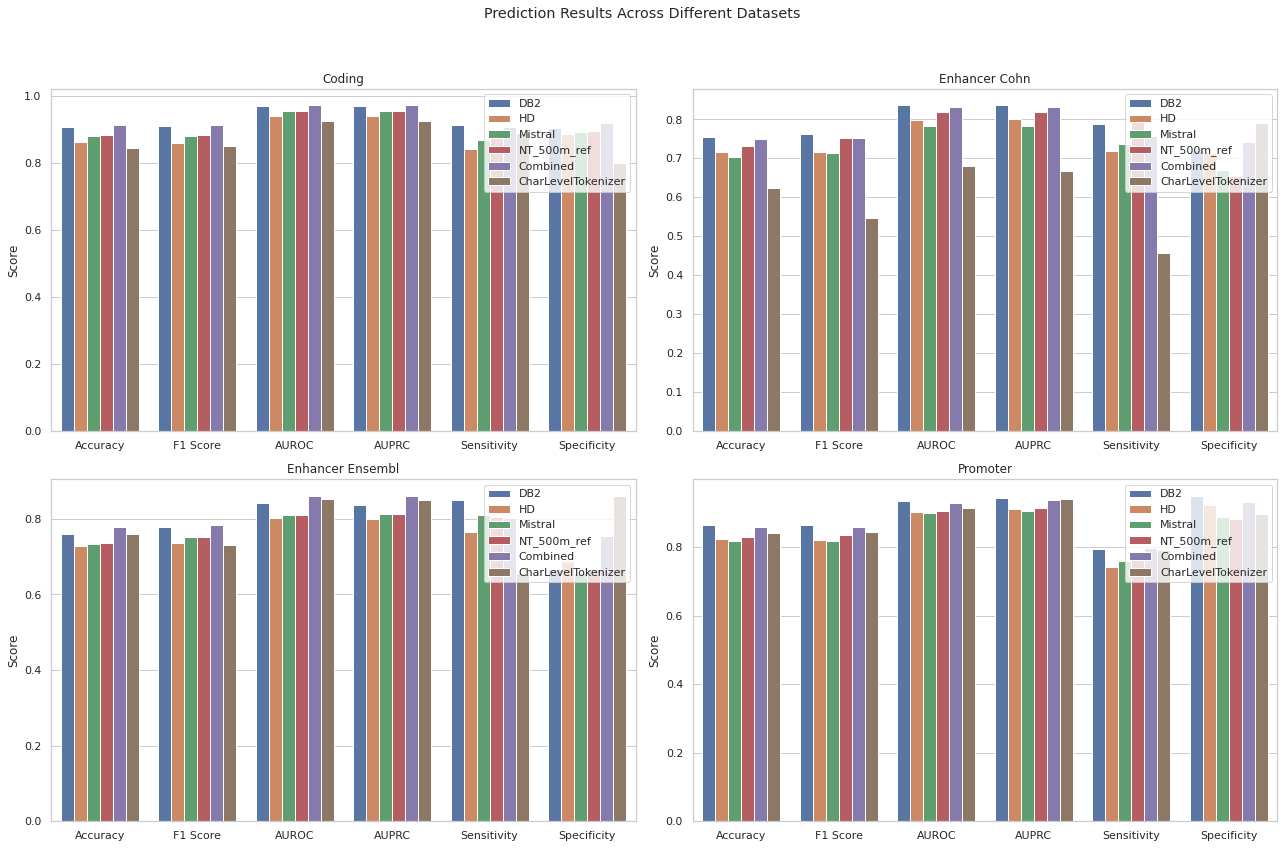

In [13]:
%matplotlib inline

# List of datasets
datasets = [coding, enhancer_cohn, enhancer_ens, promoter]
dataset_names = ['Coding', 'Enhancer Cohn', 'Enhancer Ensembl', 'Promoter']

# Combine data into a single DataFrame
combined_df = pd.concat([df.assign(Dataset=name) for df, name in zip(datasets, dataset_names)])

# Melt the DataFrame for seaborn
melted_df = combined_df.melt(id_vars=['Feature Set', 'Dataset'], var_name='Metric', value_name='Score')

# Plot settings
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Prediction Results Across Different Datasets')

# Plot each dataset
for dataset, ax in zip(dataset_names, axes.flatten()):
    subset = melted_df[melted_df['Dataset'] == dataset]
    sns.barplot(data=subset, x='Metric', y='Score', hue='Feature Set', ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('Score')
    ax.legend(loc='upper right')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [16]:
combined_df

,Feature Set,Accuracy,F1 Score,AUROC,AUPRC,Sensitivity,Specificity,Dataset
0,DB2,0.909120,0.909525,0.970761,0.971009,0.913600,0.904640,Coding
1,HD,0.864080,0.860818,0.942019,0.941665,0.840640,0.887520,Coding
2,Mistral,0.880960,0.879524,0.954561,0.955645,0.869040,0.892880,Coding
3,NT_500m_ref,0.885040,0.883907,0.954949,0.955636,0.875280,0.894800,Coding
4,Combined,0.914120,0.913529,0.972529,0.972906,0.907280,0.920960,Coding
5,CharLevelTokenizer,0.844480,0.851080,0.927048,0.924909,0.888800,0.800160,Coding
0,DB2,0.754893,0.762714,0.836127,0.836429,0.787853,0.721934,Enhancer Cohn
1,HD,0.715314,0.716131,0.798417,0.799735,0.718192,0.712435,Enhancer Cohn
2,Mistral,0.702792,0.712436,0.783000,0.783090,0.736327,0.669257,Enhancer Cohn
3,NT_500m_ref,0.732441,0.751504,0.819515,0.819039,0.809154,0.655728,Enhancer Cohn


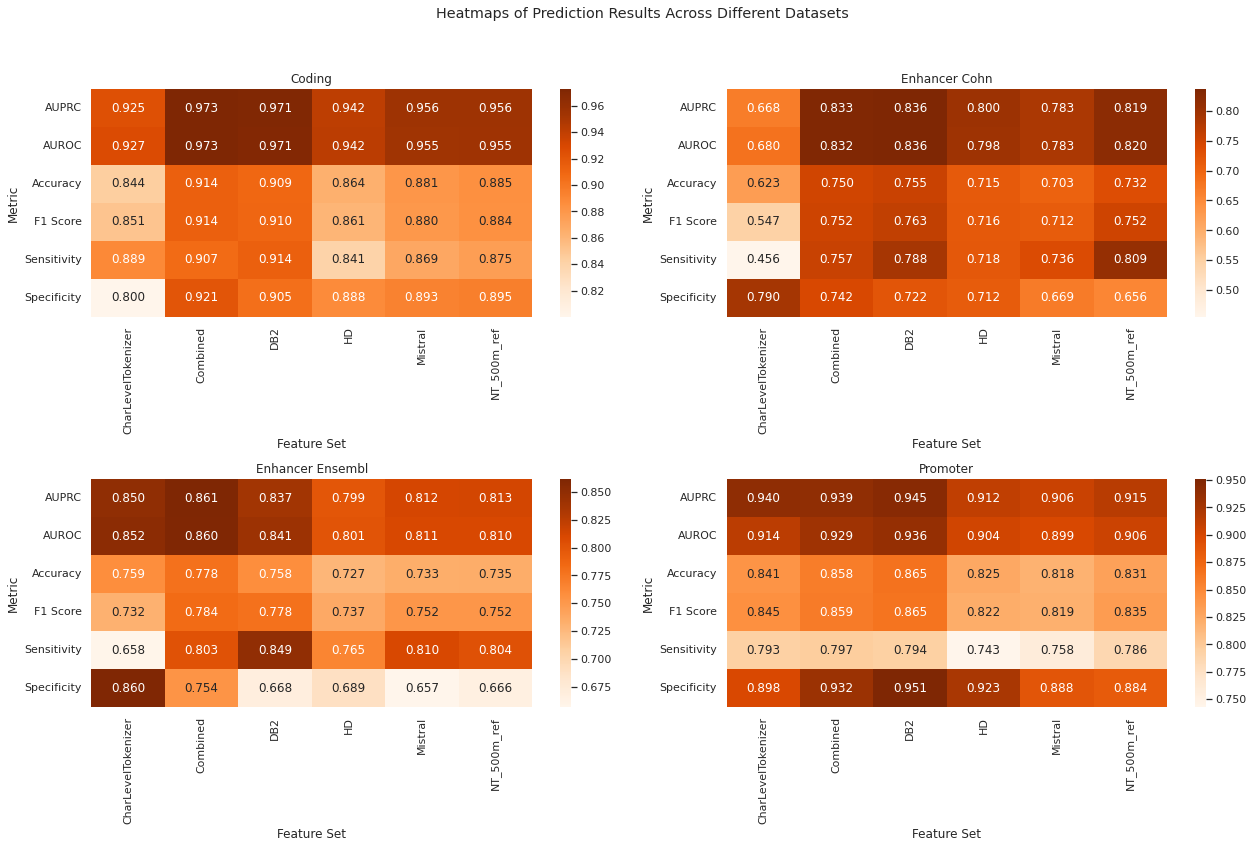

In [15]:
# List of datasets
datasets = [coding, enhancer_cohn, enhancer_ens, promoter]
dataset_names = ['Coding', 'Enhancer Cohn', 'Enhancer Ensembl', 'Promoter']

# Combine data into a single DataFrame
combined_df = pd.concat([df.assign(Dataset=name) for df, name in zip(datasets, dataset_names)])

# Melt the DataFrame for seaborn
melted_df = combined_df.melt(id_vars=['Feature Set', 'Dataset'], var_name='Metric', value_name='Score')

# Plot settings
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Heatmaps of Prediction Results Across Different Datasets')

# Plot each dataset
for dataset, ax in zip(dataset_names, axes.flatten()):
    subset = melted_df[melted_df['Dataset'] == dataset]
    heatmap_data = subset.pivot_table(index='Metric', columns='Feature Set', values='Score')
    sns.heatmap(heatmap_data, annot=True, cmap='Oranges', fmt='.3f', ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel('Feature Set')
    ax.set_ylabel('Metric')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result3/SupervisedPredictionHeatMap.pdf')
plt.show()

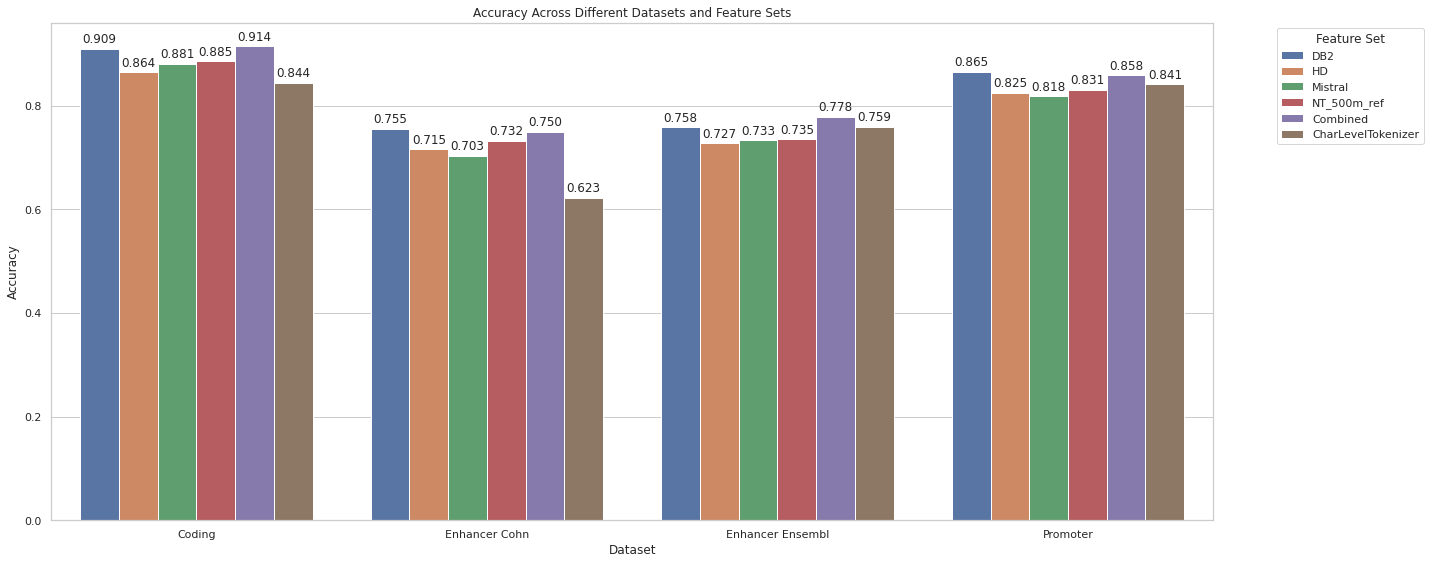

In [7]:
datasets = [coding, enhancer_cohn, enhancer_ens, promoter]
dataset_names = ['Coding', 'Enhancer Cohn', 'Enhancer Ensembl', 'Promoter']

# Combine data into a single DataFrame
combined_df = pd.concat([df.assign(Dataset=name) for df, name in zip(datasets, dataset_names)])

# Melt the DataFrame for seaborn
melted_df = combined_df.melt(id_vars=['Feature Set', 'Dataset'], var_name='Metric', value_name='Score')

# Filter for Accuracy metric
accuracy_df = melted_df[melted_df['Metric'] == 'Accuracy']

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(20, 8))
sns.barplot(data=accuracy_df, x='Dataset', y='Score', hue='Feature Set')
plt.title('Accuracy Across Different Datasets and Feature Sets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add numbers on top of bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.show()

In [ ]:
coding

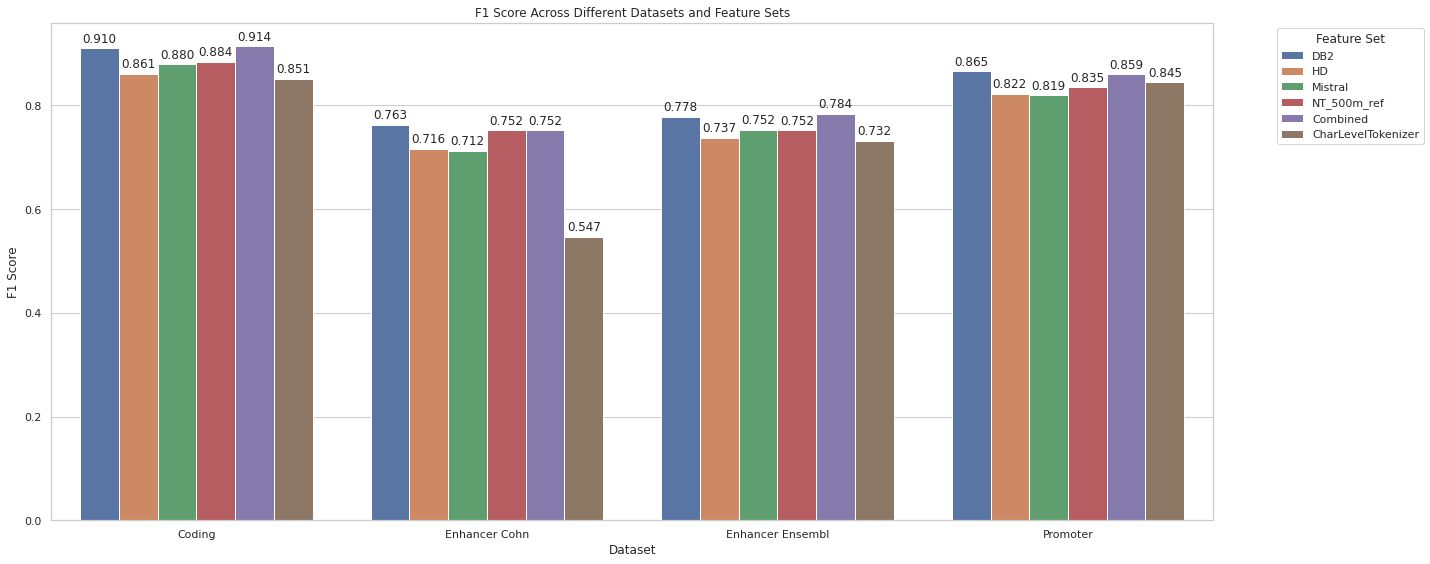

In [9]:
datasets = [coding, enhancer_cohn, enhancer_ens, promoter]
dataset_names = ['Coding', 'Enhancer Cohn', 'Enhancer Ensembl', 'Promoter']

# Combine data into a single DataFrame
combined_df = pd.concat([df.assign(Dataset=name) for df, name in zip(datasets, dataset_names)])

# Melt the DataFrame for seaborn
melted_df = combined_df.melt(id_vars=['Feature Set', 'Dataset'], var_name='Metric', value_name='Score')

# Filter for Accuracy metric
accuracy_df = melted_df[melted_df['Metric'] == 'F1 Score']

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(20, 8))
sns.barplot(data=accuracy_df, x='Dataset', y='Score', hue='Feature Set')
plt.title('F1 Score Across Different Datasets and Feature Sets')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add numbers on top of bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.show()